In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# Generating Names with a Character-Level RNN


Inspired from notebook authored by: [Sean Robertson](https://github.com/spro)



In [2]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [3]:
# Initialize an empty list to store the contents
name_list = []

# Open the file in read mode
with open('name_list.txt', 'r') as file:
    # Read each line from the file
    for line in file:
        # Strip the newline character and any extra whitespace
        clean_line = line.strip()
        # Append the clean line to the list
        name_list.append(clean_line)

In [4]:
name_list[:5]

['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']

## Creating the Network

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.h2o(hidden)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training

In [7]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random name
def randomTrainingPair():
    line = randomChoice(name_list)
    return line

In [8]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [9]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = randomTrainingPair()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

### Training the Network

In [10]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [11]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [12]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 6s (5000 5%) 2.6764
0m 12s (10000 10%) 2.4404
0m 19s (15000 15%) 1.9534
0m 25s (20000 20%) 2.4998
0m 31s (25000 25%) 2.9272
0m 37s (30000 30%) 3.1450
0m 44s (35000 35%) 2.4219
0m 50s (40000 40%) 1.9562
0m 56s (45000 45%) 2.6651
1m 3s (50000 50%) 2.5133
1m 9s (55000 55%) 2.4893
1m 15s (60000 60%) 2.9220
1m 22s (65000 65%) 2.9033
1m 28s (70000 70%) 1.6703
1m 34s (75000 75%) 2.4884
1m 41s (80000 80%) 2.1711
1m 47s (85000 85%) 2.4040
1m 54s (90000 90%) 2.1704
2m 1s (95000 95%) 1.6186
2m 7s (100000 100%) 2.6419


### Plotting the Losses

Plotting the historical loss from all\_losses shows the network
learning:




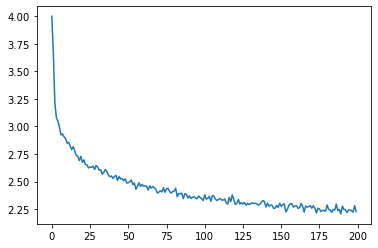

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Sampling the Network

In [18]:
max_length = 20

# Sample from a starting letter
def sample(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples and multiple starting letters
def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))

samples('ADWJRHDSAFRGWFWED')

Aller
Donn
Walle
Jerring
Ronger
Harring
Donn
Ston
Alland
Ford
Ronger
Galler
Walle
Farring
Wille
Ellan
Donn
